In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(0, '../')
from dfHelper import*


### Visual overview of data in order to choose the window size to compute amplitude

columns: Index(['InertialMeasurementUnit BACK acc_mod',
       'InertialMeasurementUnit RUA acc_mod',
       'InertialMeasurementUnit RLA acc_mod',
       'InertialMeasurementUnit LUA acc_mod',
       'InertialMeasurementUnit LLA acc_mod'],
      dtype='object')


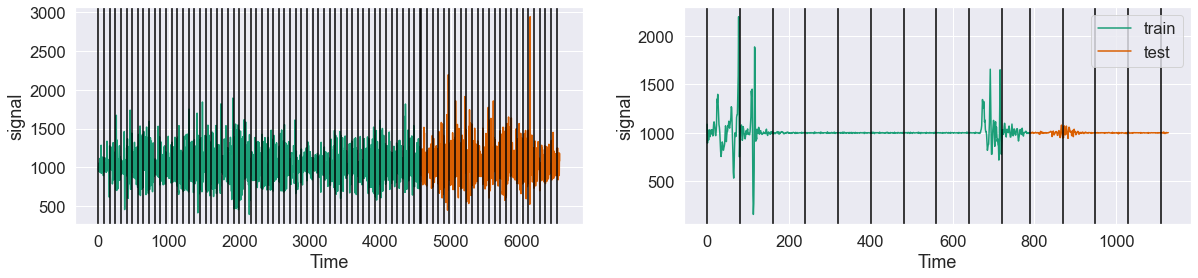

In [48]:
subject, run = 1, 1
sensors = ['IMU_acc', 'IMU_gyro','triaxial_acc']

sensor = sensors[0]
d = load_data_adl(subject, run, '../OpportunityUCIDataset')
walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])
walk, lie = get_sensor_data(walk, sensor), get_sensor_data(lie, sensor)
walk, lie = walk[walk.columns[:-8]], lie[lie.columns[:-8]]


train_frac = 0.7
print ('columns:', walk.columns)
column = walk.columns[2]

walk_train = walk[:int(len(walk)*train_frac)]
walk_test  = walk[int(len(walk)*train_frac):]
lie_train = lie[:int(len(lie)*train_frac)]
lie_test  = lie[int(len(lie)*train_frac):]

fig, ax=plt.subplots(1,2, figsize=(20, 4))
sns.set_theme(style='darkgrid', palette='Dark2', font_scale=1.5)
walk_train[column].plot(ax=ax[0], label='train')
walk_test[column].plot(ax=ax[0], label='test')
lie_train[column].plot(ax=ax[1], label='train')
lie_test[column].plot(ax=ax[1], label='test')

ax[0].legend().remove(), ax[1].legend()
ax[0].set_xlabel('Time'), ax[1].set_xlabel('Time')
ax[0].set_ylabel('signal'), ax[1].set_ylabel('signal')


# we want to create a dataset with all the amplitudes within a window of 
# size window_size, lets visualize it to have a clear idea
window_size = 80
for i in range(len(walk_train)):
    if i % window_size == 0:
        ax[0].axvline(i, color='black')
for i in range(len(lie_train)):
    if i % window_size == 0:
        ax[1].axvline(i, color='black')
for i in range(len(walk_test)):
    if i % window_size == 0:
        ax[0].axvline(len(walk_train)+i, color='black')
for i in range(len(lie_test)):
    if i % window_size == 0:
        ax[1].axvline(len(lie_train)+i, color='black')


# training of the model and test on original signals

In [73]:
def prepare_dataset(split_frac, sensor, window_size=80):
    """
    create a dataset of amplitudes for walking and laying HL activity

    split_frac: fraction of data to be used for training
    sensor: sensor to be used
    window_size: size of the window to be used for the computation of the amplitude
    """
    X, y = [], []
    # for each subject, for each run
    subjects = [1,2,3]
    runs = [1,2,3, 4, 5]
    for s in subjects:
        for r in runs:
            d = load_data_adl(subject, run, '../OpportunityUCIDataset')
            walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])
            walk, lie = get_sensor_data(walk, sensor), get_sensor_data(lie, sensor)
            walk, lie = walk[walk.columns[:-8]], lie[lie.columns[:-8]]
            for c in walk.columns:
                series = walk[c]
                for i in range(len(series)):
                    if i % window_size == 0:
                        amplitude = max(series[i:i+window_size])-min(series[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(1)
                        else: continue
            for c in lie.columns:
                series = lie[c]
                for i in range(len(series)):
                    if i % window_size == 0:
                        amplitude = max(series[i:i+window_size])-min(series[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(0)
                        else: continue
    from sklearn.utils import shuffle
    from sklearn.model_selection import train_test_split
    X, y = shuffle(X, y)

    #split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_frac)
    return X_train, X_test, y_train, y_test

In [74]:
data_IMUAcc = prepare_dataset(0.2, 'IMU_acc')
data_IMUGyro = prepare_dataset(0.2, 'IMU_gyro')
data_triaxialAcc = prepare_dataset( 0.2, 'triaxial_acc')

In [99]:
from sklearn.linear_model import LogisticRegression
clf_IMUAcc = LogisticRegression(random_state=0).fit(data_IMUAcc[0], data_IMUAcc[2])
clf_IMUGyro = LogisticRegression(random_state=0).fit(data_IMUGyro[0], data_IMUGyro[2])
clf_triaxialAcc = LogisticRegression(random_state=0).fit(data_triaxialAcc[0], data_triaxialAcc[2])

IMUAcc_accuracy = [clf_IMUAcc.score(data_IMUAcc[1], data_IMUAcc[3]), clf_IMUAcc.score(data_IMUAcc[0], data_IMUAcc[2])]
IMUGyro_accuracy = [clf_IMUGyro.score(data_IMUGyro[1], data_IMUGyro[3]), clf_IMUGyro.score(data_IMUGyro[0], data_IMUGyro[2])]
triaxialAcc_accuracy = [clf_triaxialAcc.score(data_triaxialAcc[1], data_triaxialAcc[3]), clf_triaxialAcc.score(data_triaxialAcc[0], data_triaxialAcc[2])]

print ('IMUAcc accuracy (test/train):', IMUAcc_accuracy)
print ('IMUGyro accuracy (test/train):', IMUGyro_accuracy)
print ('triaxialAcc accuracy (test/train):', triaxialAcc_accuracy)


IMUAcc accuracy (test/train): [0.979381443298969, 0.9742268041237113]
IMUGyro accuracy (test/train): [0.9752577319587629, 0.9701030927835051]
triaxialAcc accuracy (test/train): [0.9543464665415885, 0.9621638524077548]


# Test on the amplitude of the centers

In [104]:
# load the clustered signals 
def centers_amplitude(sensor, nclusters, window_size=80, metric='euclidean'):       
    """
    create a dataset of amplitudes for walking and laying HL activity working on the signal centers

    sensor: sensor to be used
    nclusters: number of clusters to be used
    window_size: size of the window to be used for the computation of the amplitude
    metric: metric to be used for the clustering
    """
      
    subjects = [1,2,3]
    runs = [1,2,3, 4]
    X, y = [], []

    for s in subjects:
        for r in runs:
            data_laying = pd.read_csv('../clustering/clustering_results_{}/subject_{}/run_{}/laying/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, sensor, nclusters))
            data_walking = pd.read_csv('../clustering/clustering_results_{}/subject_{}/run_{}/walking/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, sensor, nclusters))

            for c in range(nclusters):
                lie = data_laying['center {}'.format(c)]
                walk = data_walking['centers {}'.format(c)]
                for i in range(len(lie)):
                    if i % window_size == 0:
                        amplitude = max(lie[i:i+window_size])-min(lie[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(0)
                        else: continue
                for i in range(len(walk)):
                    if i % window_size == 0:
                        amplitude = max(walk[i:i+window_size])-min(walk[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(1)
                        else: continue
    from sklearn.utils import shuffle
    X, y = shuffle(X, y)
    return X, y            

In [109]:
results = pd.DataFrame()
for c in range(1,5):
    data_centers_IMUAcc = centers_amplitude('IMU_acc', c)
    data_centers_IMUGyro = centers_amplitude('IMU_gyro', c)
    data_centers_triaxialAcc = centers_amplitude('triaxial_acc', c)

    IMUAcc_accuracy = clf_IMUAcc.score(data_centers_IMUAcc[0], data_centers_IMUAcc[1])
    IMUGyro_accuracy = clf_IMUGyro.score(data_centers_IMUGyro[0], data_centers_IMUGyro[1])
    triaxialAcc_accuracy = clf_triaxialAcc.score(data_centers_triaxialAcc[0], data_centers_triaxialAcc[1])

    results = results.append({'clusters': c, 'IMUAcc': IMUAcc_accuracy, 'IMUGyro': IMUGyro_accuracy, 'triaxialAcc': triaxialAcc_accuracy}, ignore_index=True)
    print ('clusters:', c, 'IMUAcc accuracy:', IMUAcc_accuracy, 'IMUGyro accuracy:', IMUGyro_accuracy, 'triaxialAcc accuracy:', triaxialAcc_accuracy)
results.set_index('clusters', inplace=True)

clusters: 1 IMUAcc accuracy: 0.9680766161213089 IMUGyro accuracy: 0.9537110933758979 triaxialAcc accuracy: 0.7710706150341685
clusters: 2 IMUAcc accuracy: 0.9493216280925778 IMUGyro accuracy: 0.9437350359138069 triaxialAcc accuracy: 0.9299544419134397
clusters: 3 IMUAcc accuracy: 0.9534450651769087 IMUGyro accuracy: 0.9444001064112796 triaxialAcc accuracy: 0.9309035687167806
clusters: 4 IMUAcc accuracy: 0.9571029529130087 IMUGyro accuracy: 0.9471268954509178 triaxialAcc accuracy: 0.9322323462414579


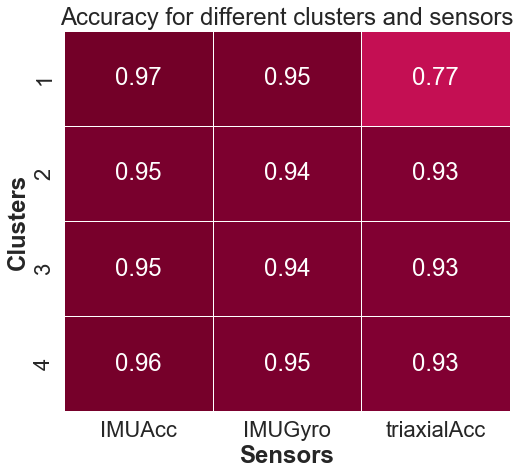

In [136]:
sns.set_theme(style='whitegrid', palette='mako', font_scale = 2)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(results, annot=True,  linewidths=0.5, linecolor='white', cmap='PuRd', vmin = 0, vmax = 1, cbar=False, ax=ax)
ax.set_yticklabels([1,2,3,4])
ax.set_ylabel('Clusters',fontweight='bold')
ax.set_title('Accuracy for different clusters and sensors')
ax.set_xlabel('Sensors',fontweight='bold')
fig.savefig('../clustering/clustering_results_euclidean/accuracy_clusters.png')